# 2D Unscented kalman filter
2次元でのUnscented kalman filterのサンプルです。
# ライブラリのインポート

In [1]:
%matplotlib inline
import numpy as np
import math, random
import matplotlib.pyplot as plt

# ランドマーククラス
下のグラフに表示されている星です。  
ロボットはこの星を目印にして自分の位置を知ります。  
今回は星の位置もロボットが覚えている設定です。  

In [2]:
class Landmarks:
    #目印となるランドマークの位置設定
    def __init__(self, array):
        self.positions = array
        
    #ランドマークの描画
    def draw(self):
        xs = [e[0] for e in self.positions]
        ys = [e[1] for e in self.positions]
        plt.scatter(xs,ys,s=300,marker="*",label="landmarks",color="orange")

# ロボットクラス
ロボットは下のグラフの赤い矢印です。

In [3]:
class Robot:
    def __init__(self, x, y, rad):
        # ステップごとのロボットの姿勢の真値が入った配列
        self.actual_poses = [np.array([x,y,rad])]

    def move(self,fw,rot):
        #ukf用に保存
        self.fw = fw
        self.rot = rot
        
        actual_fw = random.gauss(fw, fw * 0.1)    # 10%の標準偏差でばらつく
        actual_rot = random.gauss(rot, rot * 0.1) # 10%の標準偏差でばらつく
        dir_error = random.gauss(0.0, math.pi / 180.0 * 3.0) # 3[deg]の標準偏差
    
        # 異動前の位置を保存
        px, py, pt = self.actual_poses[-1]
        
        # 移動後の位置を計算
        x = px + actual_fw * math.cos(pt + dir_error)
        y = py + actual_fw * math.sin(pt + dir_error)
        t = pt + actual_rot + dir_error
        
        self.actual_poses.append(np.array([x, y, t]))
        
    def observation(self, landmarks):
        # センサの計測範囲
        sensor_max_range = 1.0           # 距離0.1 ~ 1
        sensor_min_range = 0.1
        sensor_max_angle =  math.pi / 2  # 角度90 ~ -90[deg]
        sensor_min_angle = -math.pi / 2

        # ロボットの位置姿勢を保存
        rx, ry, rt = self.actual_poses[-1]
        # 観測データ
        self.z = []
        
        # ランドマークごとに観測
        for lpos in landmarks.positions:
            true_lx, true_ly = lpos
            
            # 観測が成功したらresultをTrue
            result = True
            
            # ロボットとランドマークの距離を計算
            # センサの範囲外であればresultがFalseに
            distance = math.sqrt((rx - true_lx) ** 2 + (ry - true_ly) ** 2)
            if distance > sensor_max_range or distance < sensor_min_range:
                result = False
            
            # ロボットから見えるランドマークの方向を計算
            # こちらもセンサの範囲外であればresultがFalseに
            direction = math.atan2(true_ly - ry, true_lx - rx) - rt
            if direction > math.pi: direction -= 2 * math.pi
            if direction < - math.pi: direction += 2 * math.pi
            if direction > sensor_max_angle or direction < sensor_min_angle:
                result = False
            
            # 雑音の大きさを設定
            sigma_d = distance * 0.1    # 10%の標準偏差
            sigma_f = math.pi * 3 / 180 # 3degの標準偏差
            
            # 雑音を混ぜる
            d = random.gauss(distance,  sigma_d)
            f = random.gauss(direction, sigma_f)
            
            # 観測データを保存
            self.z.append([d, f, sigma_d, sigma_f, result])
            
    # 矢印の描画に必要な位置と方向を計算して描画
    def draw(self, sp):
        xs = [e[0] for e in self.actual_poses]
        ys = [e[1] for e in self.actual_poses]
        vxs = [math.cos(e[2]) for e in self.actual_poses]
        vys = [math.sin(e[2]) for e in self.actual_poses]
        plt.quiver(xs,ys,vxs,vys,color="red",label="actual robot motion",alpha=0.5)

# UKFクラス
UKFの処理を行うクラスです。

In [4]:
class UKF:
    def __init__(self, x, y, t):
        #パラメータ設定
        alpha = 1.0000001
        beta  = 2.0
        kappa = 0.0
        
        #次元の設定
        L     = 7.0
        
        #重み計算時に使用する
        lamda = alpha ** 2 * (L + kappa) - L
        
        #シグマポイント生成時に使用する
        self.gamma = math.sqrt(L + lamda)
        
        #重み
        self.wm = [lamda / (L + lamda)]
        self.wc = [lamda / (L + lamda) + (1 - alpha ** 2 + beta)]
        self.wm.append(1 / (2 * (L + lamda)))
        self.wc.append(1 / (2 * (L + lamda)))
        
        #共分散行列の初期値
        self.V_x = np.array([[0.005,0,0],
                             [0,0.005,0],
                             [0,0,0.005]])
        
        M_t = np.array([[0,0],
                        [0,0]])
        
        Q_t = np.array([[0,0],
                        [0,0]])
        
        #共分散行列の結合
        V_a = np.r_[np.c_[self.V_x, np.zeros([3,4])], np.c_[np.zeros([2,3]), M_t, np.zeros([2,2])], np.c_[np.zeros([2,5]), Q_t]]
        
        #シグマポイントの作成
        self.mean_x = np.array([[x], [y], [t]])
        self.sp_u = np.array([[0], [0]])
        self.sp_z = np.array([[0], [0]])
        
        sp_a = np.r_[self.mean_x, self.sp_u, self.sp_z]
        sp_p = np.r_[self.mean_x, self.sp_u, self.sp_z]
        sp_m = np.r_[self.mean_x, self.sp_u, self.sp_z]
        
        for i in range(6):
            sp_p = np.c_[sp_p, sp_a]
            sp_m = np.c_[sp_m, sp_a]
        
        sp_p = sp_p + self.gamma * np.sqrt(V_a)
        sp_m = sp_m - self.gamma * np.sqrt(V_a)
        
        self.sp_a = np.c_[sp_a, sp_p, sp_m]
        
    def generate_sp(self, robot):
        #共分散行列の作成
        #制御、観測の雑音をシグマポイントに反映
        alpha = 0.1
        
        #移動の共分散行列
        M_t = np.sqrt(np.array([[alpha * robot.fw ** 2 + alpha * robot.rot ** 2,0],
                                [0,alpha * robot.fw ** 2 + alpha * robot.rot ** 2]]))
        
        #観測の共分散行列
        #ランドマークごとに異なるため、observationメソッドで生成される
        #ここでは一旦0を保存
        Q_t = np.array([[0,0],
                        [0,0]])
        
        #固有値、固有ベクトル計算
        eigen = np.linalg.eig(self.V_x)
        sigma_1 = math.sqrt(eigen[0][0]) * eigen[1][0]
        sigma_2 = math.sqrt(eigen[0][1]) * eigen[1][1]
        sigma_3 = math.sqrt(eigen[0][2]) * eigen[1][2]
        
        self.V_x = np.array([sigma_1,
                             sigma_2,
                             sigma_3])
        
        V_a = np.r_[np.c_[self.V_x, np.zeros([3,4])], np.c_[np.zeros([2,3]), M_t, np.zeros([2,2])], np.c_[np.zeros([2,5]), Q_t]]
        
        #シグマポイントの更新
        sp_a = np.r_[self.mean_x, self.sp_u, self.sp_z]
        sp_p = np.r_[self.mean_x, self.sp_u, self.sp_z]
        sp_m = np.r_[self.mean_x, self.sp_u, self.sp_z]
        
        for i in range(6):
            sp_p = np.c_[sp_p, sp_a]
            sp_m = np.c_[sp_m, sp_a]
        
        sp_p = sp_p + self.gamma * V_a
        sp_m = sp_m - self.gamma * V_a
        
        self.sp_a = np.c_[sp_a, sp_p, sp_m]
        
    def move(self, robot, landmarks):
        for i in range(len(self.sp_a[0])):
            #移動前の位置姿勢保存
            bm_x, bm_y, bm_t = self.sp_a[0:3,i:i + 1]
            sigma_fw  = self.sp_a[3][i]
            sigma_rot = self.sp_a[4][i]
            
            #各シグマポイントにおける制御雑音の保存
            sp_fw, sp_rot = self.sp_a[3:5,i:i + 1]
            
            #fw前進、rot回転
            am_x = bm_x + (robot.fw + sigma_fw) * math.cos(bm_t)
            am_y = bm_y + (robot.fw + sigma_fw) * math.sin(bm_t)
            am_t = bm_t + robot.rot + sigma_rot
            
            #シグマポイント移動
            self.sp_a[0:3,i:i+1] = np.array([am_x, am_y, am_t])
            
        #移動後のシグマポイントの平均位置姿勢
        self.mean_x = self.wm[0] * self.sp_a[0:3,0:1]
        for i in range(len(self.sp_a[0]) - 1):
            self.mean_x += self.wm[1] * self.sp_a[0:3,i + 1:i + 2]
        
        self.V_x = self.wc[0] * (self.sp_a[0:3,0:1] - self.mean_x).dot((self.sp_a[0:3,0:1] - self.mean_x).T)
        for i in range(len(self.sp_a[0]) - 1):
            self.V_x += self.wc[1] * (self.sp_a[0:3,i + 1:i + 2] - self.mean_x).dot((self.sp_a[0:3,i + 1:i + 2] - self.mean_x).T)
            
    def observation(self, robot, landmarks):
        for landmark_ID in range(len(robot.z)):
            r_d, r_f, sigma_d, sigma_f, result = robot.z[landmark_ID]
            z = np.array([[r_d],[r_f]])
            
            #ロボットが観測できたランドマークについてのみ処理する
            if result:
                l_x, l_y = landmarks.positions[landmark_ID]
                
                #観測誤差の追加
                Q_t = np.array([[sigma_d ** 2,0],
                                [0,sigma_f ** 2]])
                
                self.sp_a[5:7,6:8] = np.sqrt(Q_t)
                self.sp_a[5:7,13:15] = -np.sqrt(Q_t)
                
                #シグマポイントからの観測
                sp_zs = []
                
                for i in range(len(self.sp_a[0])):
                    #シグマポイントの位置姿勢を保存
                    sp_x, sp_y, sp_t = self.sp_a[0:3,i:i + 1]
                    sigma_d = self.sp_a[5][i]
                    sigma_f = self.sp_a[6][i]
                    
                    # ロボットとランドマークの距離を計算
                    sp_d = math.sqrt((sp_x - l_x) ** 2 + (sp_y - l_y) ** 2) + sigma_d
                    
                    # シグマポイントから見えるランドマークの方向を計算
                    sp_f = math.atan2(l_y - sp_y, l_x - sp_x) - sp_t[0] + sigma_f
                    if sp_f > math.pi: sp_f -= 2 * math.pi
                    if sp_f < - math.pi: sp_f += 2 * math.pi
                    
                    sp_zs.append(np.array([[sp_d],[sp_f]]))
                
                #シグマポイントにおける平均観測結果
                mean_z = self.wm[0] * sp_zs[0]
                for i in range(len(self.sp_a[0]) - 1):
                    mean_z += self.wm[1] * sp_zs[i + 1]
                
                #シグマポイントにおける観測結果の分散
                V_z = self.wc[0] * (sp_zs[0] - mean_z).dot((sp_zs[0] - mean_z).T)
                for i in range(len(self.sp_a[0]) - 1):
                    V_z += self.wc[1] * (sp_zs[i+1] - mean_z).dot((sp_zs[i+1] - mean_z).T)
                
                #シグマポイントの位置と観測結果の共分散
                V_xz = self.wc[0] * (self.sp_a[0:3,0:1] - self.mean_x).dot((sp_zs[0] - mean_z).T)
                for i in range(len(self.sp_a[0]) - 1):
                    V_xz += self.wc[1] * (self.sp_a[0:3,i+1:i+2] - self.mean_x).dot((sp_zs[i+1] - mean_z).T)
                
                """
                kalman filter
                """
                #カルマンゲイン生成
                K_t = V_xz.dot(np.linalg.inv(V_z))
                
                #filtering後の推定位置の平均を保存
                mean_x_tmp = self.mean_x + K_t.dot(z - mean_z)
                
                #filtering後の推定位置の分散を保存
                V_x_tmp = self.V_x - K_t.dot(V_z).dot(K_t.T)
                
                #共分散行列の対角成分が全て生の値の場合のみ更新
                if V_x_tmp[0][0] > 0 and V_x_tmp[1][1] > 0 and V_x_tmp[2][2] > 0:
                    self.mean_x = mean_x_tmp
                    self.V_x = V_x_tmp
                
    #描画関数
    def draw(self):        
        xy = np.c_[self.sp_a[0:3,0:3],self.sp_a[0:3,8:10]]

        xs = [e[0] for e in xy.T]
        ys = [e[1] for e in xy.T]
        vxs = [math.cos(e[2]) for e in xy.T]
        vys = [math.sin(e[2]) for e in xy.T]
        plt.quiver(xs,ys,vxs,vys,color="blue",label="sigma points",alpha=0.3)

# 描画クラス
シグマポイント、ロボット、ランドマークを順に描画します。  

In [5]:
def draw(i):
    # グラフの設定
    fig = plt.figure(i, figsize=(8,8))
    sp = fig.add_subplot(111,aspect='equal')
    sp.set_xlim(-1.0,1.0)
    sp.set_ylim(-0.5,1.5)
    
    ukf.draw()
    robot.draw(sp)
    actual_landmarks.draw()
    
    plt.legend()

# シミュレーション開始

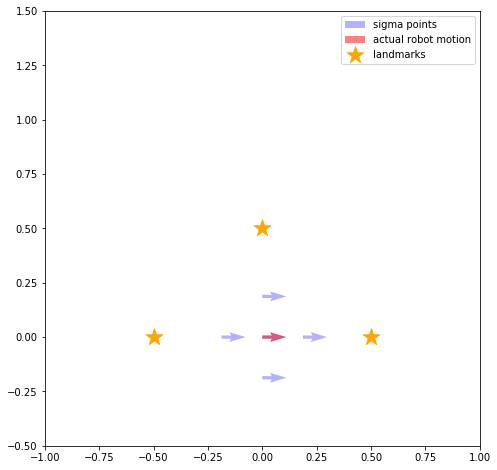

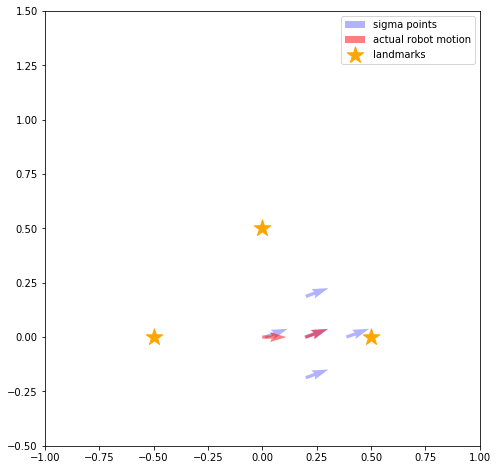

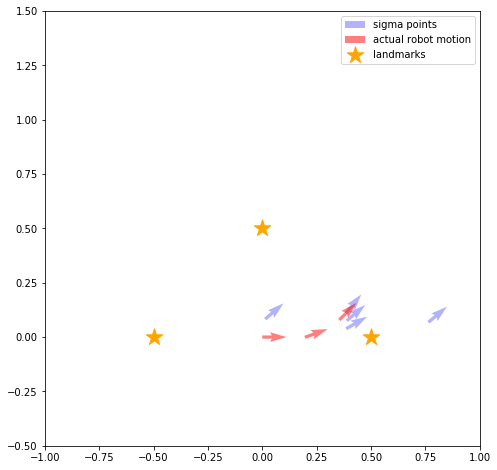

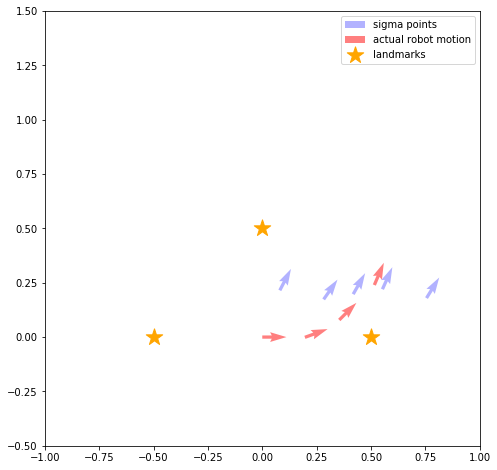

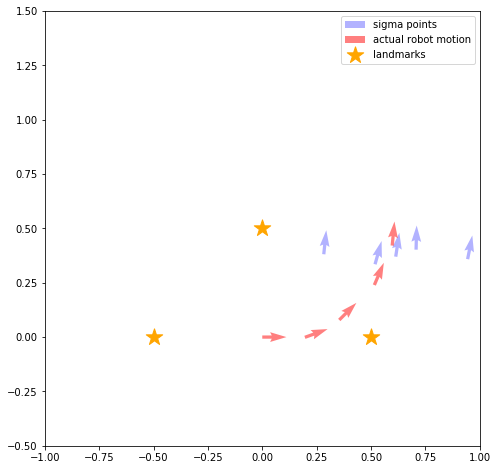

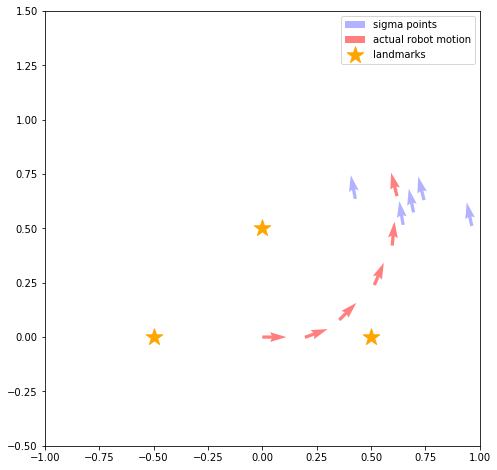

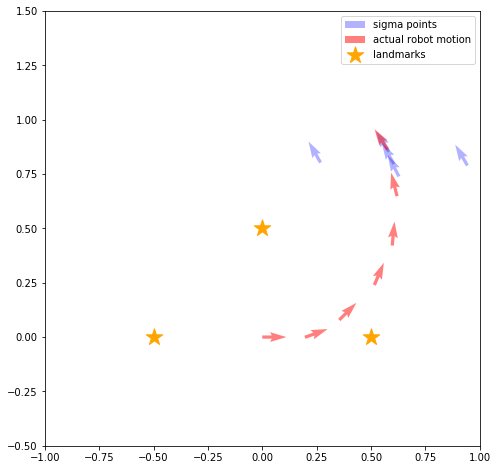

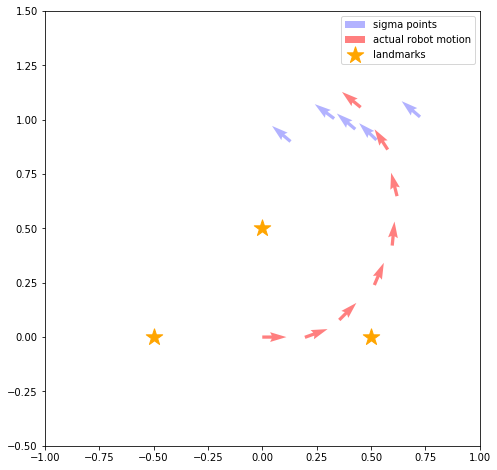

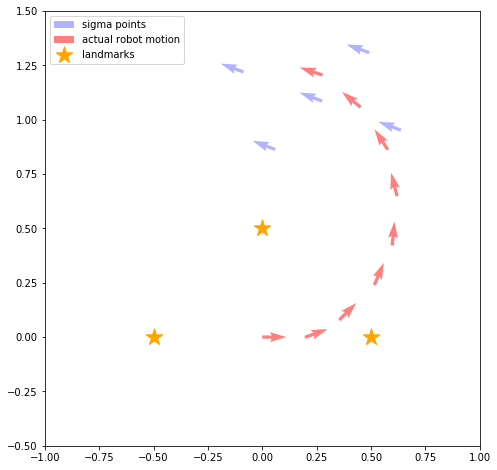

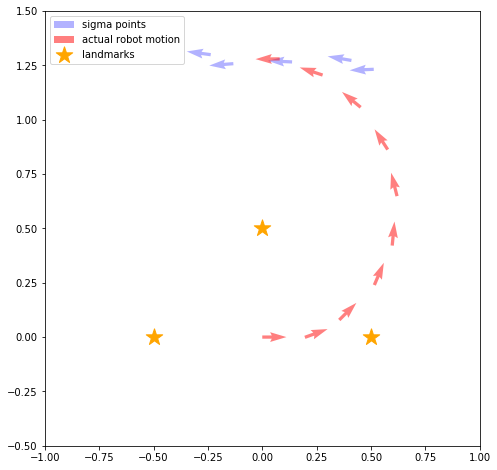

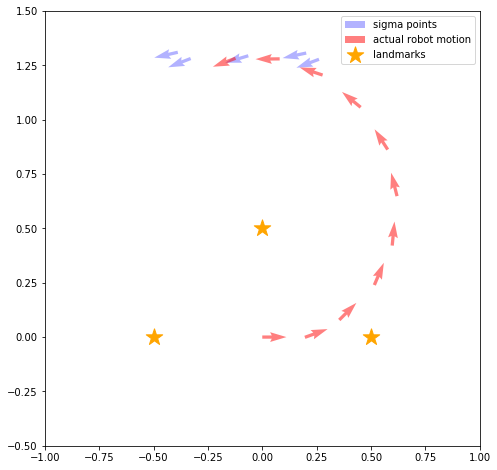

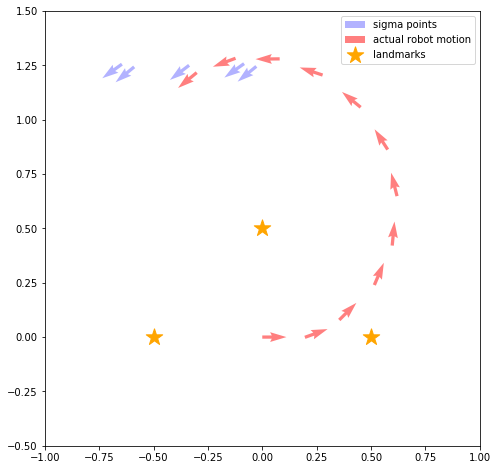

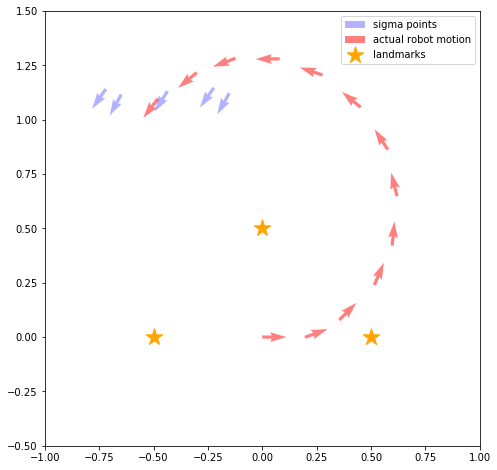

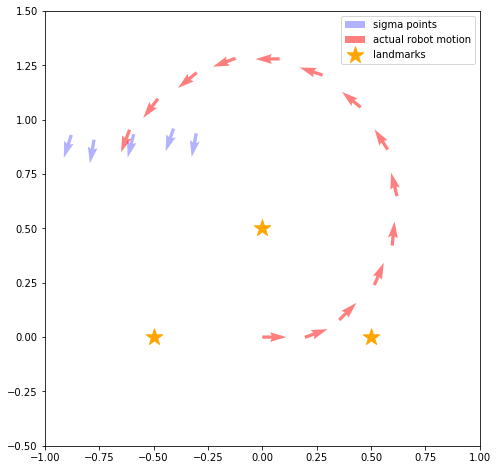

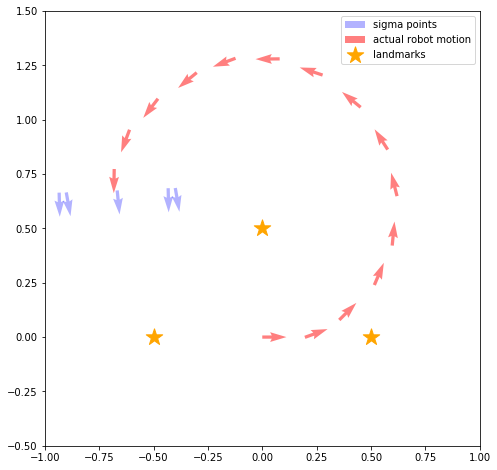

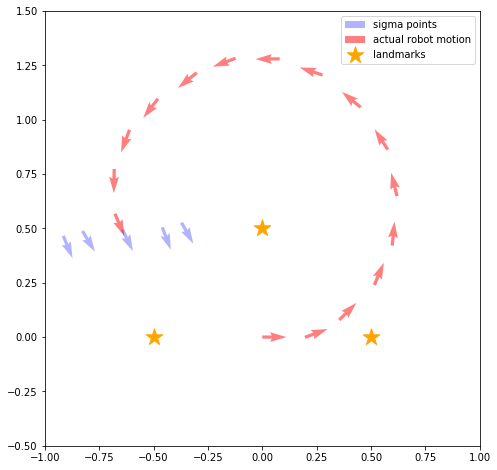

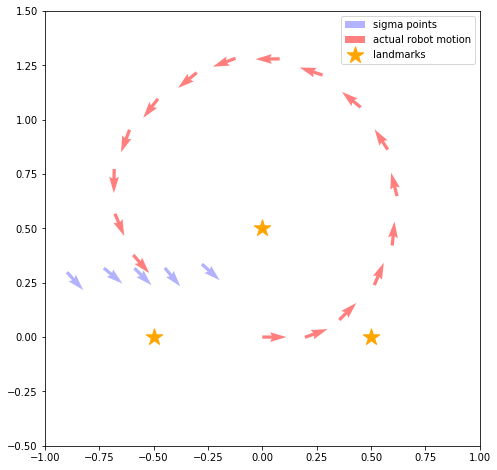

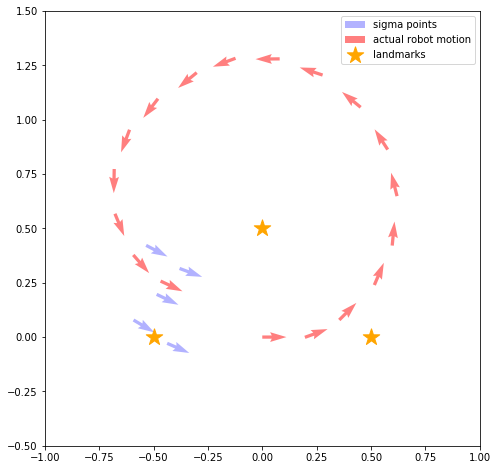

In [6]:
actual_landmarks = Landmarks([[-0.5,0.0],[0.0,0.5],[0.5,0.0]])
robot = Robot(0,0,0)
ukf = UKF(0,0,0)
draw(0)

for i in range(1, 18):
    robot.move(0.2,math.pi / 180.0 * 20)
    robot.observation(actual_landmarks)
    ukf.generate_sp(robot)
    ukf.move(robot, actual_landmarks)
    ukf.observation(robot, actual_landmarks)
    draw(i)